# fastMRI
Use python 3.6+

In [1]:
ll -h /home/ubuntu/cs230/data/fastmri/raw/file1000000.h5

-rw-rw-r-- 1 ubuntu 91M May 31 18:39 /home/ubuntu/cs230/data/fastmri/raw/file1000000.h5


In [2]:
import os, glob
import h5py # for loading .h5 files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [4]:
import cs230_project_utilities as utils

# Loading the data

In [5]:
# Location of directory H5Exports_AnimiX/ (downloaded from Olivier's link)
dataset_directory = '/home/ubuntu/cs230/data/fastmri/raw'

In [6]:
def find_dataset_files(dataset_directory):
    # Find .h5 and .txt files in `dataset_directory`
    # Assuming at most one name.h5 and one name.txt file in `dataset_directory`.
    h5_file_pattern = os.path.join(dataset_directory, '*.h5')
    text_file_pattern = os.path.join(dataset_directory, '*.txt')
    h5_paths = glob.glob(h5_file_pattern)
    text_paths = glob.glob(text_file_pattern)
    print('Found {} .h5 files and {} .txt files.'.format(len(h5_paths), len(text_paths)))
    
    # Merge .h5 and .txt paths into one data structure: a dict where key is filename
    # without extension and value is dict {'h5': h5_path, 'text': text_path}.
    get_filename = lambda path: os.path.splitext(os.path.basename(path))[0]
    files = {}
    for path in h5_paths:
        filename = get_filename(path)
        files[filename] = {'h5': path}
    for path in text_paths:
        filename = get_filename(path)
        files[filename]['text'] = path
      
    return files

In [7]:
# Find all the files in our dataset
files = find_dataset_files(dataset_directory)

Found 1 .h5 files and 0 .txt files.


In [8]:
files['file1000000']['h5']

'/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5'

In [9]:
# Load example files
example = files['file1000000']
print(example)

{'h5': '/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5'}


In [10]:
h5 = example['h5']

In [13]:
# Handle .h5 files

def inspect_h5_file(path):
    with h5py.File(path, 'r') as f:
        # Looks like .h5 files are like dictionaries
        print('Found keys: {}'.format(f.keys()))
        
        # Let's find all the nested keys
        print('\nFinding nested keys...')
        show_keys_for_h5_file(path)
        
        # Unwrap the data stored in the keys
        # known keys: 'clasificacion', 'images', 'kspace/mag', 'kspace/phase'
        print('\nUnwrapping data at known keys...')
        ismrmrd_header = f['ismrmrd_header']
        kspace = f['kspace']
        reconstruction_esc = f['reconstruction_esc']
        reconstruction_rss = f['reconstruction_rss']
        print(ismrmrd_header)
        print(kspace)
        print(reconstruction_esc)
        print(reconstruction_rss)

def show_keys_for_h5_file(path):
    '''
    Convenience function for printing the nested keys in an
    .h5 file.
    '''
    def print_nested_keys(key, value):
        print(key)
        for k, v in value.attrs.items():
            print('{}: {}'.format(key, val))

    with h5py.File(path, 'r') as f:
        f.visititems(print_nested_keys)
        
def read_h5_file(path):
    '''
    Reads a .h5 file from `path`, unwrapping data stored in the known
    keys: 'clasificacion', 'images', 'kspace/mag', 'kspace/phase'.
    '''
    with h5py.File(path, 'r') as f:
        metadata = f['ismrmrd_header'].value
        kspace = f['kspace'].value
        reconstruction_esc = f['reconstruction_esc'].value
        reconstruction_rss = f['reconstruction_rss'].value
        
#     # Convert to float32 and scale data to [0, 1]
#     images = images.astype(np.float32)
#     images -= images.min(axis=(1, 2), keepdims=True)
#     images /= images.max(axis=(1, 2), keepdims=True)
    print(kspace.shape)
    
#     # Additional conversion scaling here with magnitude data.
#     # Most ML and scientific frameworks expect data to be in [0, 1].
#     magnitude = magnitude.astype(np.float32)
#     magnitude -= magnitude.min(axis=(1, 2), keepdims=True)
#     magnitude /= magnitude.max(axis=(1, 2), keepdims=True)
    
#     phase = phase.astype(np.float32)
    # Don't scale phase (it represents an angle, so it's always in [0, pi])
    
    return {'metadata': metadata,
            'kspace': kspace,
            'reconstruction_esc': reconstruction_esc,
            'reconstruction_rss': reconstruction_rss}
    
# Handle .txt files

def inspect_text_file(path):
    with open(path, 'rb') as f:
        print(f.read())


In [14]:
# Let's look at a single .h5 file
inspect_h5_file(h5)

Found keys: KeysView(<HDF5 file "file1000000.h5" (mode r)>)

Finding nested keys...
ismrmrd_header
kspace
reconstruction_esc
reconstruction_rss

Unwrapping data at known keys...
<HDF5 dataset "ismrmrd_header": shape (), type "|O">
<HDF5 dataset "kspace": shape (35, 640, 368), type "<c8">
<HDF5 dataset "reconstruction_esc": shape (35, 320, 320), type "<f4">
<HDF5 dataset "reconstruction_rss": shape (35, 320, 320), type "<f4">


# Visualizing the data

In [15]:
# Finally, we can see the raw data
h5_data = read_h5_file(h5)
print(h5_data.keys())

metadata = h5_data['metadata']
kspace = h5_data['kspace']
reconstruction_esc = h5_data['reconstruction_esc']
reconstruction_rss = h5_data['reconstruction_rss']

# (Note: shape of magnitude and phase are different from image)
print(kspace.shape, reconstruction_esc.shape, reconstruction_rss.shape)

(35, 640, 368)
dict_keys(['metadata', 'kspace', 'reconstruction_esc', 'reconstruction_rss'])
(35, 640, 368) (35, 320, 320) (35, 320, 320)


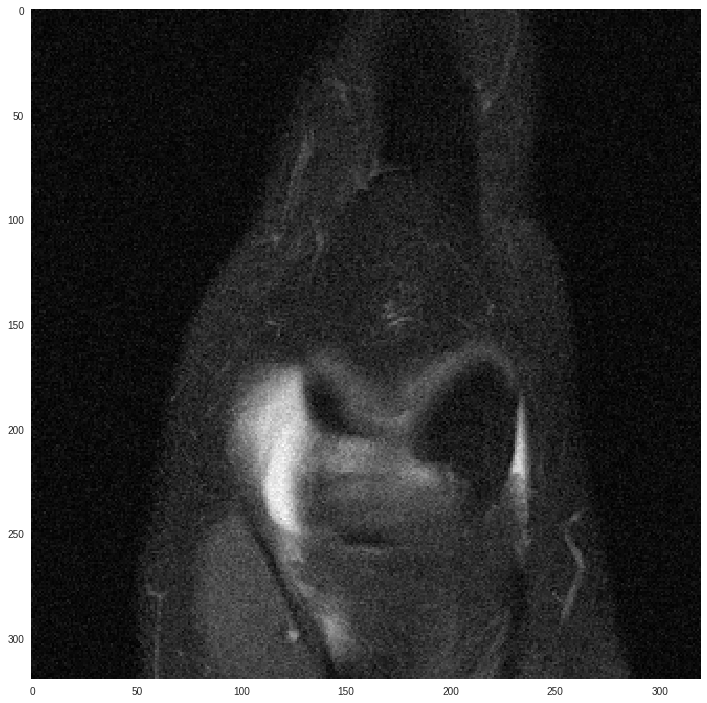

In [16]:
utils.plot.imshowgray(reconstruction_esc[10])

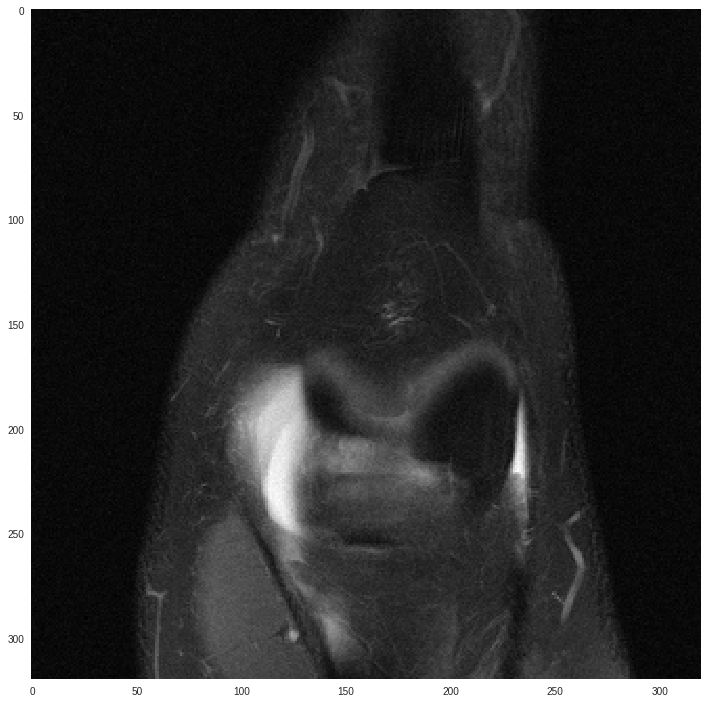

In [17]:
utils.plot.imshowgray(reconstruction_rss[10])

In [18]:
def center_crop(data, shape):
    """
    Apply a center crop to the input image or batch of complex images.
    Args:
        data (np.ndarray): The complex input tensor to be center cropped. It should
            have at least 2 dimensions and the cropping is applied along dimensions
            0 and 1.
        shape (int, int): The output shape. The shape should be smaller than the
            corresponding dimensions of data.
    Returns:
        np.ndarray: The center cropped image
    """
    assert 0 < shape[0] <= data.shape[0]
    assert 0 < shape[1] <= data.shape[1]
    w_from = (data.shape[0] - shape[0]) // 2
    h_from = (data.shape[1] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[w_from:w_to, h_from:h_to, ...]

In [19]:
def ifft2d(x):
    x = np.fft.ifftshift(x, (0, 1))
    x = np.fft.ifft2(x, norm='ortho')
    x = np.fft.fftshift(x, (0, 1))
    return x

def fft2d(x):
    x = np.fft.ifftshift(x, (0, 1))
    x = np.fft.fft2(x, norm='ortho')
    x = np.fft.fftshift(x, (0, 1))
    return x

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


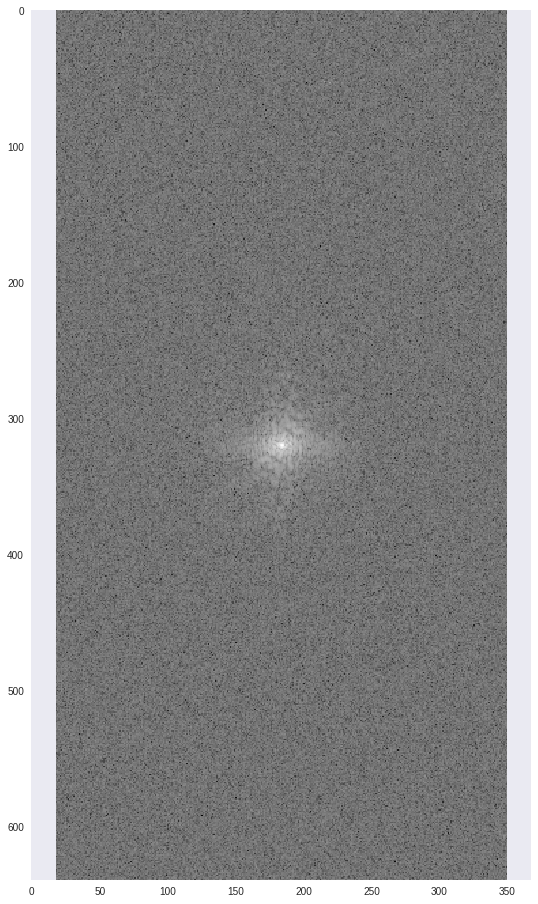

In [20]:
utils.plot.imshowfft(kspace[10])

In [21]:
out_numpy = ifft2d(kspace[10])
print(out_numpy.shape)
out_numpy = center_crop(out_numpy, (320, 320))
print(out_numpy.shape)

(640, 368)
(320, 320)


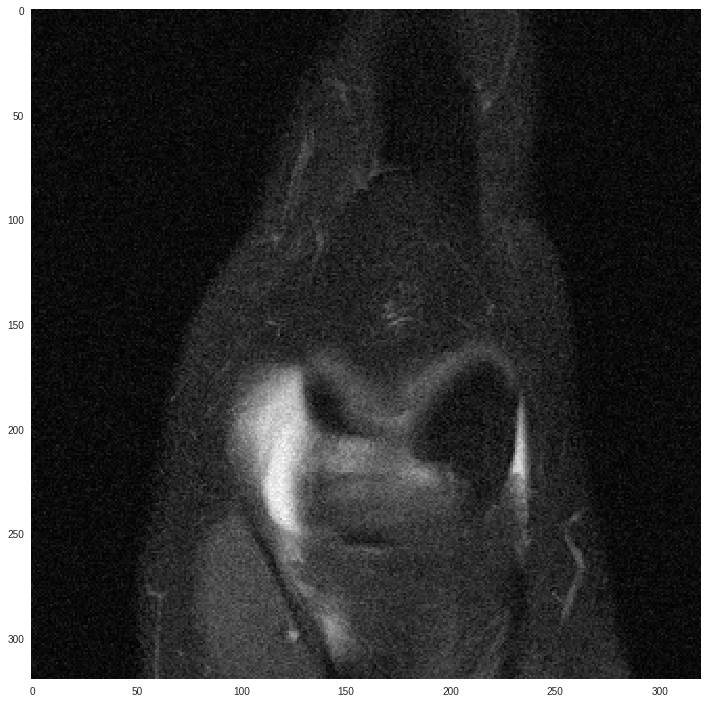

In [22]:
utils.plot.imshowgray(np.abs(out_numpy))

In [23]:
np.allclose(reconstruction_esc[10], np.abs(out_numpy))

True

In [24]:
np.allclose(reconstruction_rss[10], np.abs(out_numpy), atol=1e-4)

True

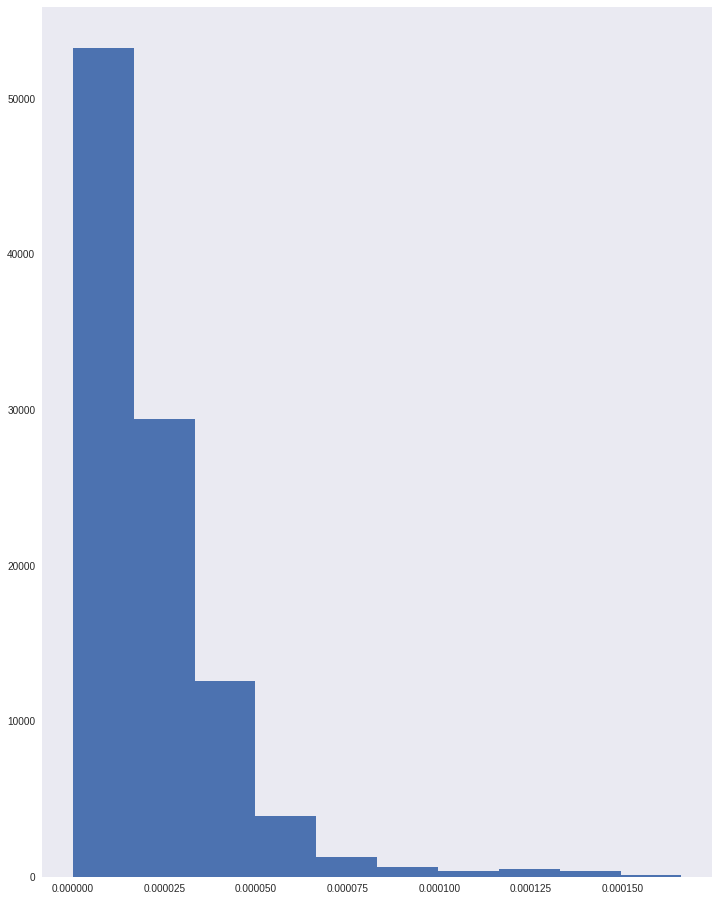

In [25]:
plt.hist(np.abs(out_numpy).flatten());

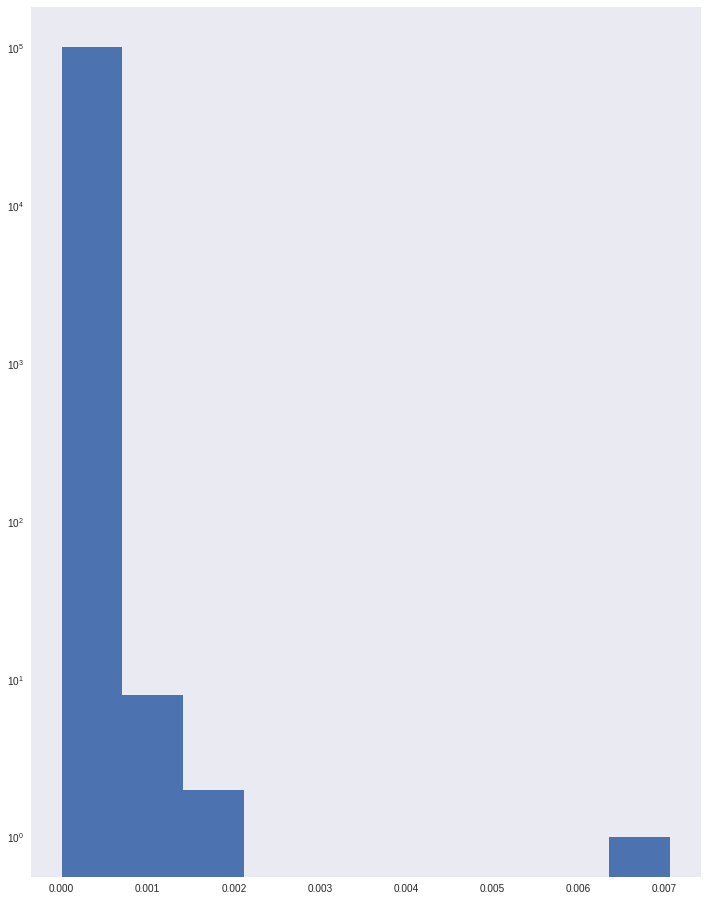

In [26]:
out_numpy = fft2d(reconstruction_rss[10])
plt.hist(np.abs(out_numpy).flatten(), log=True);

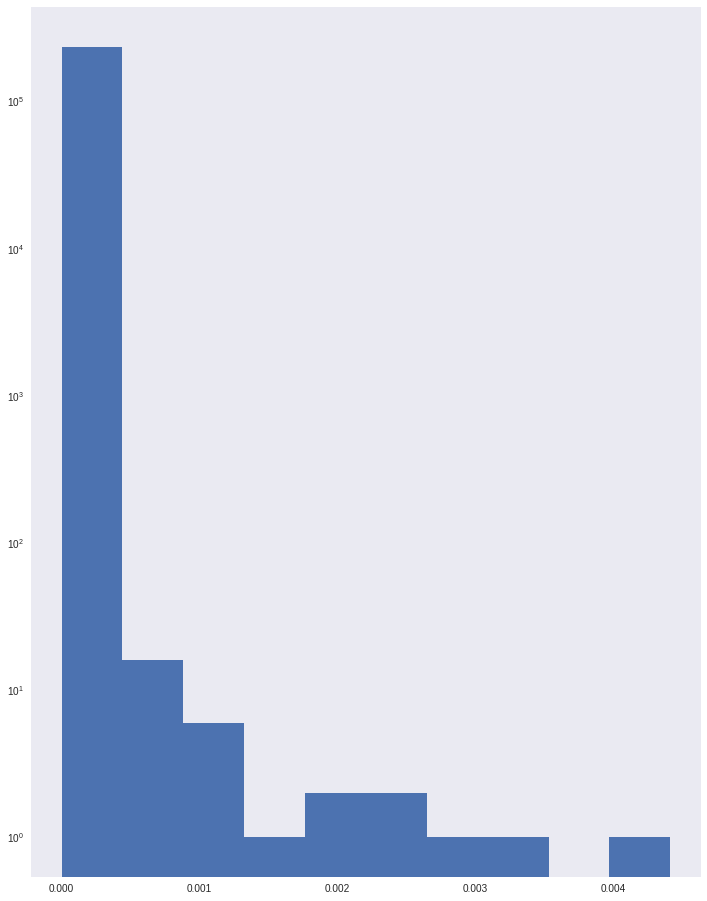

In [27]:
plt.hist(np.abs(kspace[10]).flatten(), log=True);

In [28]:
kspace[10].shape, out_numpy.shape

((640, 368), (320, 320))

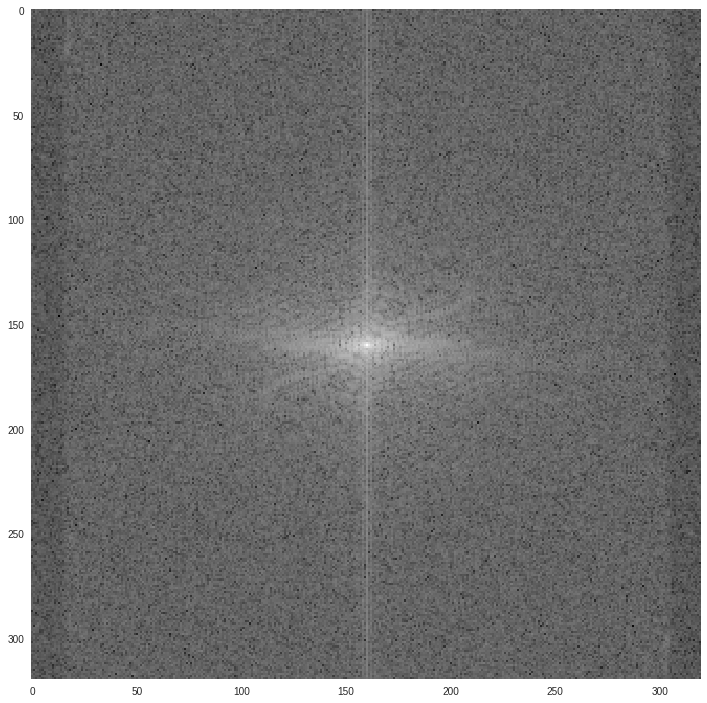

In [29]:
utils.plot.imshowfft(out_numpy)

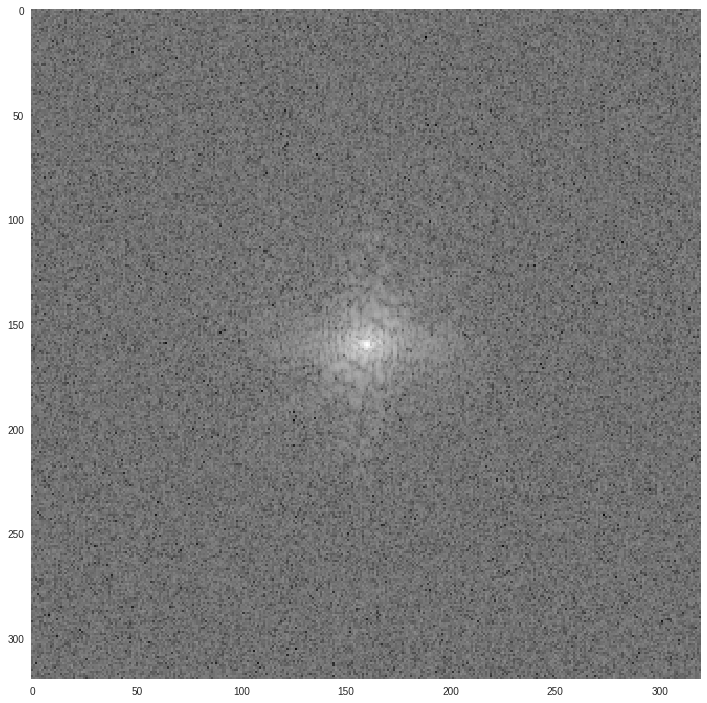

In [30]:
utils.plot.imshowfft(center_crop(kspace[10], (320, 320)))

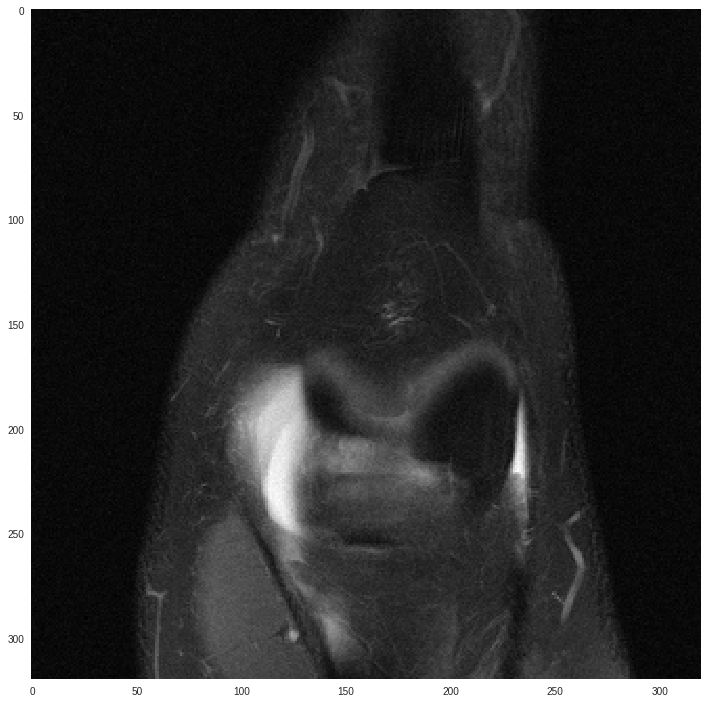

In [31]:
utils.plot.imshowgray(np.abs(ifft2d(out_numpy)))

In [32]:
np.allclose(np.abs(ifft2d(out_numpy)), reconstruction_esc[10], atol=1e-4)

True

In [33]:
np.allclose(np.abs(ifft2d(out_numpy)), reconstruction_rss[10], atol=1e-4)

True

In [34]:
def apply_mask(data, mask_func, seed=None):
    """
    Subsample given k-space by multiplying with a mask.
    Args:
        data (torch.Tensor): The input k-space data. This should have at least 3 dimensions, where
            dimensions -3 and -2 are the spatial dimensions, and the final dimension has size
            2 (for complex values).
        mask_func (callable): A function that takes a shape (tuple of ints) and a random
            number seed and returns a mask.
        seed (int or 1-d array_like, optional): Seed for the random number generator.
    Returns:
        (tuple): tuple containing:
            masked data (torch.Tensor): Subsampled k-space data
            mask (torch.Tensor): The generated mask
    """
    shape = np.array(data.shape)
    shape[:-3] = 1
    mask = mask_func(shape, seed)
    return data * mask, mask

In [49]:
class MaskFunc:
    """
    MaskFunc creates a sub-sampling mask of a given shape.
    The mask selects a subset of columns from the input k-space data. If the k-space data has N
    columns, the mask picks out:
        1. N_low_freqs = (N * center_fraction) columns in the center corresponding to
           low-frequencies
        2. The other columns are selected uniformly at random with a probability equal to:
           prob = (N / acceleration - N_low_freqs) / (N - N_low_freqs).
    This ensures that the expected number of columns selected is equal to (N / acceleration)
    It is possible to use multiple center_fractions and accelerations, in which case one possible
    (center_fraction, acceleration) is chosen uniformly at random each time the MaskFunc object is
    called.
    For example, if accelerations = [4, 8] and center_fractions = [0.08, 0.04], then there
    is a 50% probability that 4-fold acceleration with 8% center fraction is selected and a 50%
    probability that 8-fold acceleration with 4% center fraction is selected.
    """

    def __init__(self, center_fractions, accelerations):
        """
        Args:
            center_fractions (List[float]): Fraction of low-frequency columns to be retained.
                If multiple values are provided, then one of these numbers is chosen uniformly
                each time.
            accelerations (List[int]): Amount of under-sampling. This should have the same length
                as center_fractions. If multiple values are provided, then one of these is chosen
                uniformly each time. An acceleration of 4 retains 25% of the columns, but they may
                not be spaced evenly.
        """
        if len(center_fractions) != len(accelerations):
            raise ValueError('Number of center fractions should match number of accelerations')

        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.rng = np.random.RandomState()

    def __call__(self, shape, seed=None):
        """
        Args:
            shape (iterable[int]): The shape of the mask to be created. The shape should have
                at least 3 dimensions. Samples are drawn along the second last dimension.
            seed (int, optional): Seed for the random number generator. Setting the seed
                ensures the same mask is generated each time for the same shape.
        Returns:
            torch.Tensor: A mask of the specified shape.
        """
        if len(shape) < 3:
            raise ValueError('Shape should have 3 or more dimensions')

        self.rng.seed(seed)
        num_cols = shape[-2]

        choice = self.rng.randint(0, len(self.accelerations))
        center_fraction = self.center_fractions[choice]
        acceleration = self.accelerations[choice]

        # Create the mask
        num_low_freqs = int(round(num_cols * center_fraction))

        prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
        mask = self.rng.uniform(size=num_cols) < prob
        
        print('num_cols:', num_cols)
        print('num_low_freqs:', num_low_freqs)
        print('prob:', prob)
        
        print(mask.sum())
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad:pad + num_low_freqs] = True

        # Reshape the mask
        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols
        
        mask = np.reshape(mask, mask_shape).astype(np.float32)
#         mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))

        return mask

In [80]:
kspace_fully_sampled = np.expand_dims(kspace[10], -1)

In [82]:
subsampling_mask_function = MaskFunc(center_fractions=[0.08, 0.04], accelerations=[4, 8])

In [83]:
subsampling_mask = subsampling_mask_function(shape=kspace_fully_sampled.shape)

num_cols: 368
num_low_freqs: 15
prob: 0.08781869688385269
27


In [68]:
kspace_subsampled = subsampling_mask * kspace_fully_sampled

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


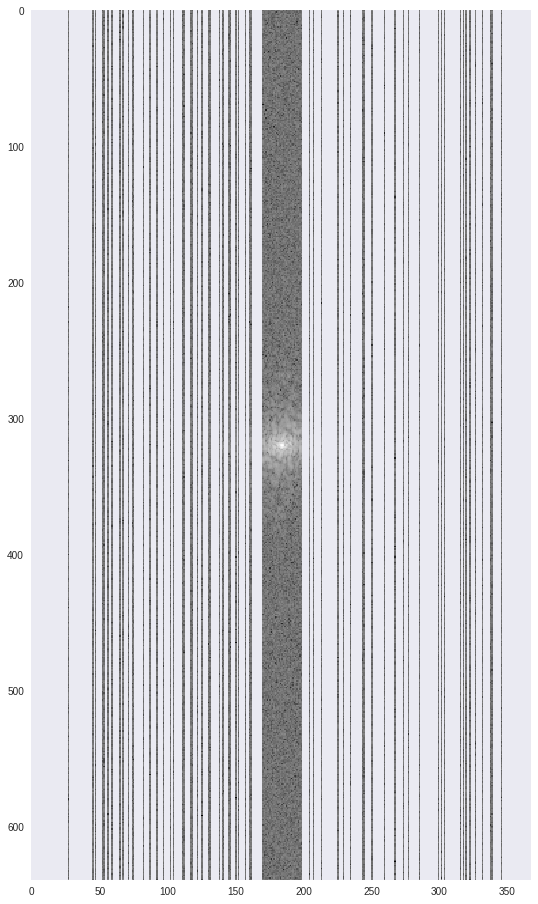

In [84]:
utils.plot.imshowfft(kspace_subsampled.squeeze())

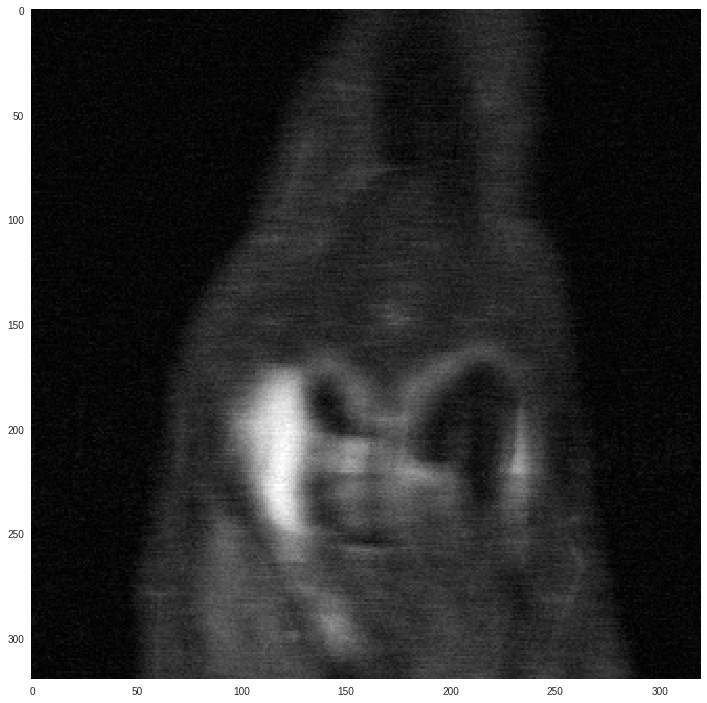

In [85]:
utils.plot.imshowgray(center_crop(np.abs(ifft2d(kspace_subsampled.squeeze())), (320, 320)))

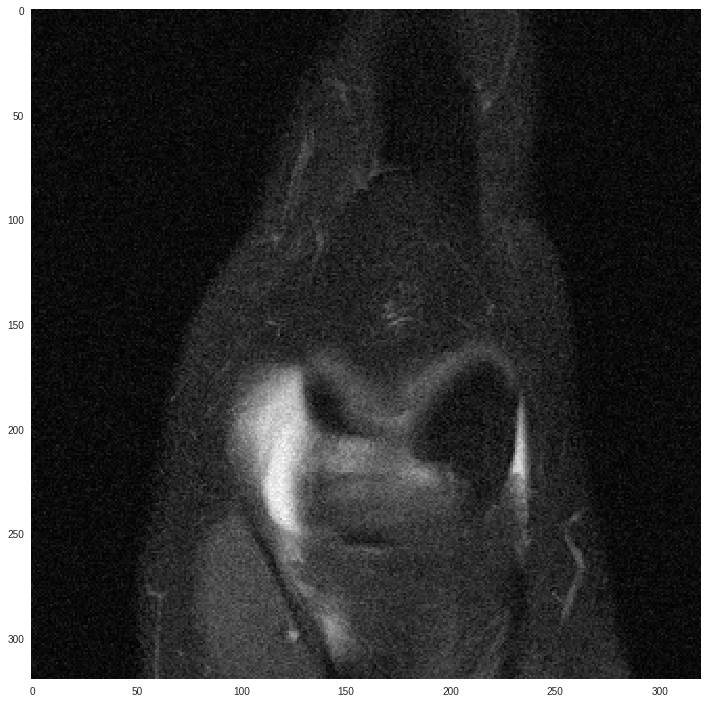

In [86]:
utils.plot.imshowgray(center_crop(np.abs(ifft2d(kspace_fully_sampled.squeeze())), (320, 320)))

In [155]:
# May want:
def normalize(data, mean, stddev, eps=0.):
    """
    Normalize the given tensor using:
        (data - mean) / (stddev + eps)
    Args:
        data (torch.Tensor): Input data to be normalized
        mean (float): Mean value
        stddev (float): Standard deviation
        eps (float): Added to stddev to prevent dividing by zero
    Returns:
        torch.Tensor: Normalized tensor
    """
    return (data - mean) / (stddev + eps)

PSNR of reconstrution: 34.2621596248
Mask preserves 54.33% of FFT coefficients


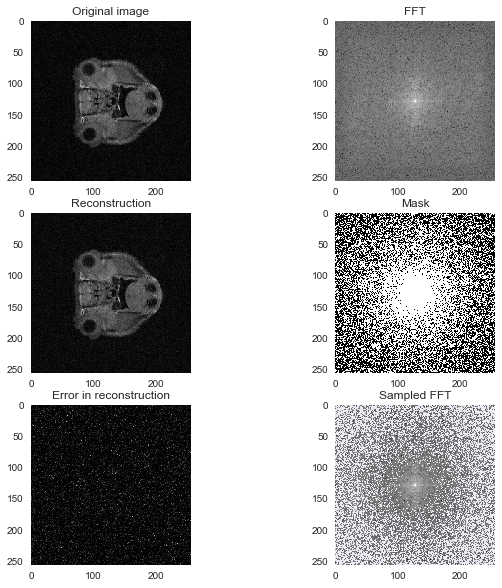

In [20]:
# Load masks for seeing how reconstruction works with sampled k-space data.

def load_mask_and_pdf_data():
    data = np.load('brain.npz')
    # brain_image is complex-valued
    brain_image, uniform_mask, vardens_mask, uniform_pdf, vardens_pdf = (data['im'], data['mask_unif'],
        data['mask_vardens'], data['pdf_unif'], data['pdf_vardens'])
    return brain_image, uniform_mask, vardens_mask, uniform_pdf, vardens_pdf

_, uniform_mask, vardens_mask, uniform_pdf, vardens_pdf = load_mask_and_pdf_data()

# Get center crop of mask because this data has smaller shape
image = images[0]
mask = np.ones_like(image)
mask = vardens_mask[image.shape[0]//2:-image.shape[0]//2, image.shape[0]//2:-image.shape[0]//2]
pdf = vardens_pdf[image.shape[0]//2:-image.shape[0]//2, image.shape[0]//2:-image.shape[0]//2]

# Run reconstruction
utils.reconstruction_demo.reconstruct_image_from_undersampled_fourier_transform(image, mask, pdf)

### Plot magnitude of FFT

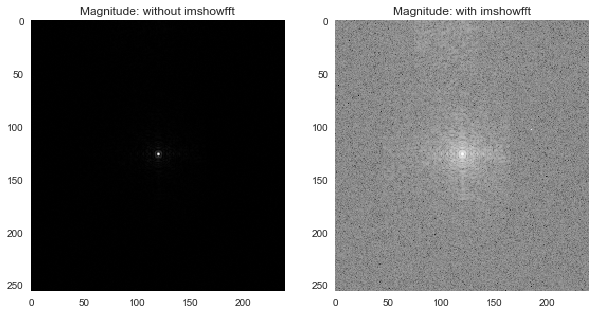

In [21]:
plt.rcParams['figure.figsize'] = (10, 10)

# Should use imshowfft (which takes log of magnitude) here because without it,
# can't visualize the higher frequencies (FFT coefficients are mostly high
# around the center == lower frequencies).

# Plot magnitude
plt.subplot(1, 2, 1)
plt.title('Magnitude: without imshowfft')
utils.plot.imshowgray(magnitude[0])

plt.subplot(1, 2, 2)
plt.title('Magnitude: with imshowfft')
utils.plot.imshowfft(magnitude[0])

### Plot phase of FFT

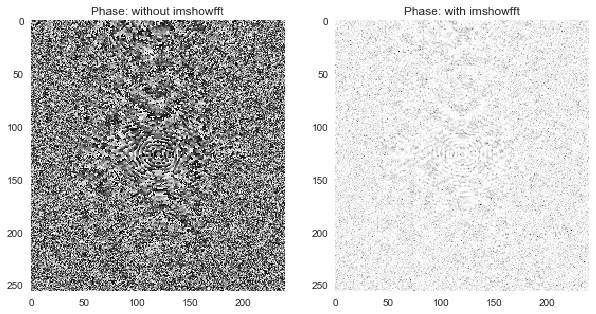

In [22]:
# Plot phase (probably don't want to use imshowfft for phase)
plt.subplot(1, 2, 1)
plt.title('Phase: without imshowfft')
utils.plot.imshowgray(phase[0])

plt.subplot(1, 2, 2)
plt.title('Phase: with imshowfft')
utils.plot.imshowfft(phase[0])

# Reconstruct an image from magnitude and phase

Error in FFT magnitude: 3.13614806093e-20
Error in FFT phase: 6.27353347621e-07


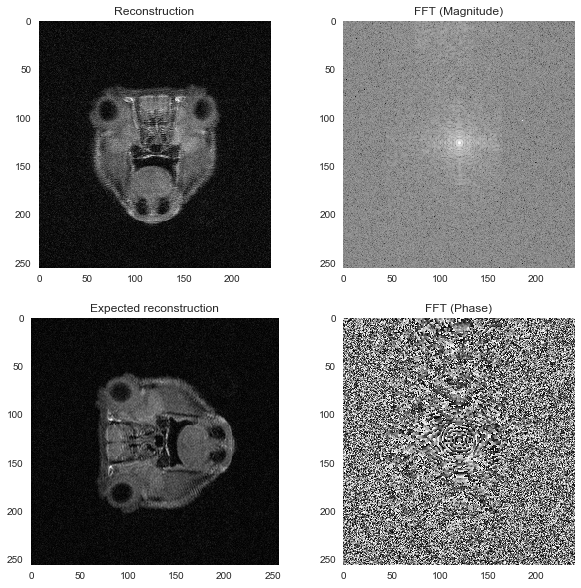

In [23]:
# Construct FFT (k-space data) from magnitude and phase
fft = magnitude[0] * np.exp(1j * phase[0])

# Take the inverse FFT
ifft = utils.signal_processing.ifft_2D_centered(fft)

plt.subplot(2, 2, 1)
plt.title('Reconstruction')
utils.plot.imshowgray(np.abs(ifft))

plt.subplot(2, 2, 2)
plt.title('FFT (Magnitude)')
utils.plot.imshowfft(np.abs(fft))

plt.subplot(2, 2, 3)
plt.title('Expected reconstruction')
utils.plot.imshowgray(images[0])

plt.subplot(2, 2, 4)
plt.title('FFT (Phase)')
utils.plot.imshowgray(np.angle(fft))

# Note: shape of magnitude and phase are different from image.
# Because of this, the reconstruction shape is different from the
# image shape and so we can't compare the image and reconstruction directly.
# How will we solve this?

# This check to make sure we are correctly combining magnitude and phase to construct the full, complex-valued FFT.
print('Error in FFT magnitude: {}'.format(utils.signal_processing.mean_square_error(np.abs(fft), magnitude[0])))
print('Error in FFT phase: {}'.format(utils.signal_processing.mean_square_error(np.angle(fft), phase[0])))
